# Import & Basic checking dataset

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

In [2]:
house = pd.read_csv('/Users/jiwanhwang/Documents/GitHub/Practice_MachineLearning/house-prices-advanced-regression-techniques/train.csv')
house_df = house.copy()
house_df.head(3)

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500


In [3]:
house_df.shape

(1460, 81)

In [4]:
house_df.dtypes.value_counts()

object     43
int64      35
float64     3
dtype: int64

In [5]:
## Count Null values 
isnull_columns = house_df.isnull().sum()
isnull_columns[isnull_columns > 0].sort_values(ascending=False)

PoolQC          1453
MiscFeature     1406
Alley           1369
Fence           1179
FireplaceQu      690
LotFrontage      259
GarageYrBlt       81
GarageType        81
GarageFinish      81
GarageQual        81
GarageCond        81
BsmtFinType2      38
BsmtExposure      38
BsmtFinType1      37
BsmtCond          37
BsmtQual          37
MasVnrArea         8
MasVnrType         8
Electrical         1
dtype: int64

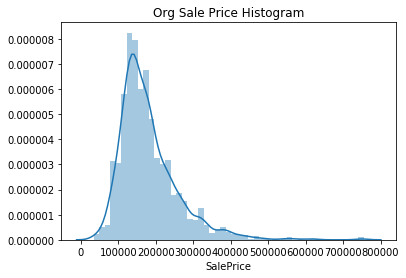

In [6]:
## Check the distribution of target variable for regression analysis
plt.title("Org Sale Price Histogram")
sns.distplot(house_df['SalePrice'])

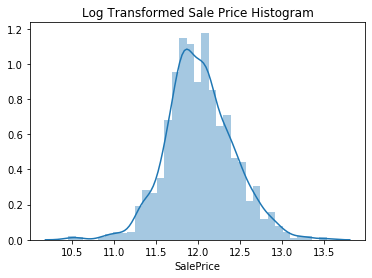

In [7]:
## Change the distribution of SalePrice to normal distribution using log transforamtion
plt.title('Log Transformed Sale Price Histogram')
sns.distplot(np.log1p(house_df['SalePrice']))

## Preprocessing

In [8]:
# Log Transformation: Target variable, SalePrice
original_SalePrice = house_df['SalePrice']
house_df['SalePrice'] = np.log1p(house_df['SalePrice'])

In [9]:
## Remove the variables with too many null values and not neccessary id varialbe
house_df.drop(['Id', 'PoolQC', 'MiscFeature', 'Alley', 'Fence', 'FireplaceQu'], axis=1, inplace=True)

In [10]:
## Fill AVG values for null values 
house_df.fillna(house_df.mean(), inplace=True)

In [11]:
## Check null values in DataFrame
null_column_count = house_df.isnull().sum()[house_df.isnull().sum() > 0]
house_df.dtypes[null_column_count.index]

MasVnrType      object
BsmtQual        object
BsmtCond        object
BsmtExposure    object
BsmtFinType1    object
BsmtFinType2    object
Electrical      object
GarageType      object
GarageFinish    object
GarageQual      object
GarageCond      object
dtype: object

In [12]:
## OneHot Encoding with .get_dummies
house_df_ohe = pd.get_dummies(house_df)
house_df_ohe.shape

(1460, 271)

In [13]:
## Check null values in DataFrame again after OneHot Encoding
null_column_count = house_df_ohe.isnull().sum()[house_df_ohe.isnull().sum() > 0]
house_df_ohe.dtypes[null_column_count.index]

Series([], dtype: object)

In [14]:
###### curious
type(house_df.isnull().sum())

pandas.core.series.Series

## Evaluation function

In [20]:
def get_rmse(model):
    pred = model.predict(X_test)
    mse = mean_squared_error(y_test, pred)
    rmse = np.sqrt(mse)
    print(model.__class__.__name__, 'Log transformed RMSE:', np.round(rmse, 3)) 
    # since target value was already log-transformed
    return rmse

def get_rmses(models):
    rmses = []
    for model in models:
        rmse = get_rmse(model)
        rmses.append(rmse)
    return rmses

# Linear Regression Model (incl. Ridge & Lasso): fit, predict, and evaluate

In [21]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

In [22]:
y = house_df_ohe['SalePrice']
X = house_df_ohe.drop('SalePrice', axis =1, inplace=False)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156)

In [23]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge()
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso()
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression Log transformed RMSE: 0.132
Ridge Log transformed RMSE: 0.128
Lasso Log transformed RMSE: 0.176


[0.13189576579153964, 0.12750846334052982, 0.17628250556471406]

** Lasso has the highest rmse among 3 models, so Lasso probably eeds hyperparameter tuning.

In [24]:
def get_top_bottom_coef(model, n=10):
    coef = pd.Series(model.coef_, index=X.columns)
    
    coef_high = coef.sort_values(ascending=False).head(n)
    coef_low = coef.sort_values(ascending=False).tail(n)
    return coef_high, coef_low

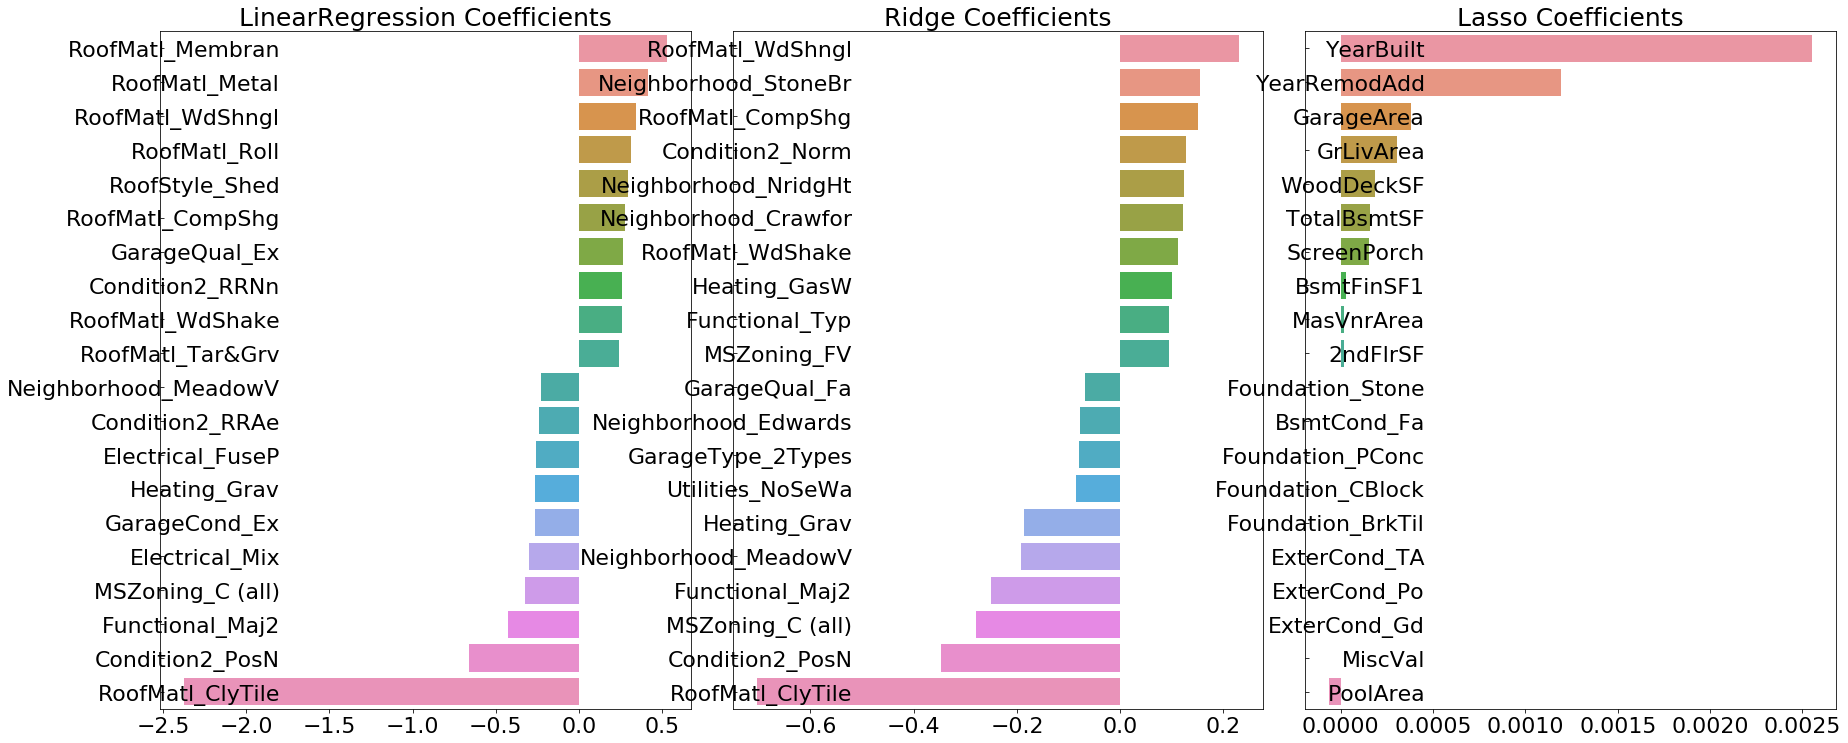

In [29]:
def visualize_coefficient(models):
    fig, axs = plt.subplots(figsize=(24, 10), nrows=1, ncols=3)
    fig.tight_layout()
    
    for i, model in enumerate(models):
        coef_high, coef_low = get_top_bottom_coef(model)
        coef_concat = pd.concat([coef_high, coef_low])
        
        axs[i].set_title(model.__class__.__name__+' Coefficients', size=25)
        axs[i].tick_params(axis='y', direction='in', pad=-120)
        
        for label in (axs[i].get_xticklabels()+axs[i].get_yticklabels()):
            label.set_fontsize(22)
        
        sns.barplot(x=coef_concat.values, y=coef_concat.index, ax=axs[i])
        
        
        
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

** OLS based LR and Ridge's coefficaients are similar but Lasso's are different.

### 5-fold CV

In [33]:
from sklearn.model_selection import cross_val_score

def get_avg_rmse_cv(models):
    for model in models:
        rmse_list = np.sqrt(-1*cross_val_score(model, X, y, scoring="neg_mean_squared_error", cv=5))
        rmse_avg = np.mean(rmse_list)
        print('{0} CV RMSE list: {1}'.format(model.__class__.__name__, np.round(rmse_list,3)))
        print('{0} CV AVG RMSE: {1}'.format(model.__class__.__name__, np.round(rmse_avg,3)))

models=[lr_reg, ridge_reg, lasso_reg]
get_avg_rmse_cv(models)

LinearRegression CV RMSE list: [0.135 0.165 0.168 0.111 0.198]
LinearRegression CV AVG RMSE: 0.155
Ridge CV RMSE list: [0.117 0.154 0.142 0.117 0.189]
Ridge CV AVG RMSE: 0.144
Lasso CV RMSE list: [0.161 0.204 0.177 0.181 0.265]
Lasso CV AVG RMSE: 0.198


### Hyperparameter Tuning

In [73]:
from sklearn.model_selection import GridSearchCV

def print_best_params(model, param_grid):
    grid_model = GridSearchCV(model, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
    grid_model.fit(X, y)
    rmse = np.sqrt(-1*grid_model.best_score_)
    print('{0} 5-FOLD-CV Best AVG RMSE: {1}, Best alpha: {2}'.format(model.__class__.__name__, 
                                                                     np.round(rmse, 4), grid_model.best_params_))
    return grid_model.best_estimator_
    
ridge_params = {'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}

print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5-FOLD-CV Best AVG RMSE: 0.1125, Best alpha: {'alpha': 8}
Lasso 5-FOLD-CV Best AVG RMSE: 0.1122, Best alpha: {'alpha': 0.001}


Lasso(alpha=0.001, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

## Fit, Evaluate with train_test_split and best parameter

In [37]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge(alpha=12)
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression Log transformed RMSE: 0.132
Ridge Log transformed RMSE: 0.124
Lasso Log transformed RMSE: 0.12


[0.13189576579153964, 0.12387044279987375, 0.11995999974065165]

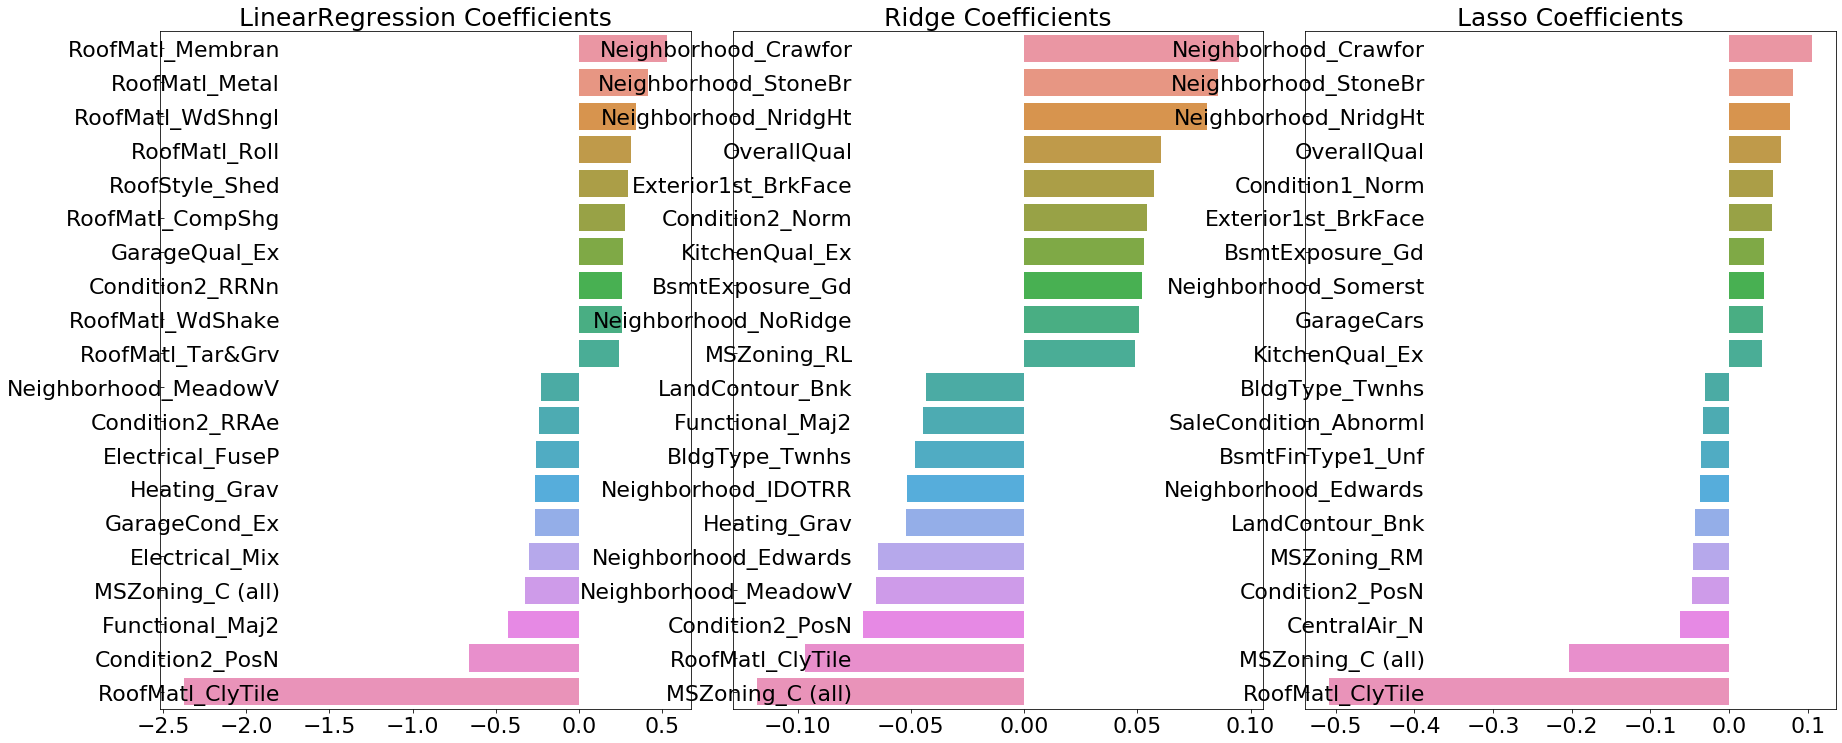

In [38]:
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

## More preprocessing dataset: 1. feature set distribution, 2. outlier

In [44]:
## 1. feature set distribution 
from scipy.stats import skew

features_index = house_df.dtypes[house_df.dtypes != 'object'].index

skew_features = house_df[features_index].apply(lambda x: skew(x))
print(type(skew_features))
# Only columns with skew >=1
skew_features_top = skew_features[skew_features > 1]

print(skew_features_top.sort_values(ascending=False))


<class 'pandas.core.series.Series'>
MiscVal          24.451640
PoolArea         14.813135
LotArea          12.195142
3SsnPorch        10.293752
LowQualFinSF      9.002080
KitchenAbvGr      4.483784
BsmtFinSF2        4.250888
ScreenPorch       4.117977
BsmtHalfBath      4.099186
EnclosedPorch     3.086696
MasVnrArea        2.673661
LotFrontage       2.382499
OpenPorchSF       2.361912
BsmtFinSF1        1.683771
WoodDeckSF        1.539792
TotalBsmtSF       1.522688
MSSubClass        1.406210
1stFlrSF          1.375342
GrLivArea         1.365156
dtype: float64


In [45]:
house_df[skew_features_top.index] = np.log1p(house_df[skew_features_top.index])

In [48]:
house_df_ohe = pd.get_dummies(house_df)
y = house_df_ohe['SalePrice']
X = house_df_ohe.drop('SalePrice', axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156)

In [49]:
ridge_params = {'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}

print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5-FOLD-CV Best AVG RMSE: 0.1275, Best alpha: {'alpha': 10}
Lasso 5-FOLD-CV Best AVG RMSE: 0.1252, Best alpha: {'alpha': 0.001}


In [50]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge(alpha=10)
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression Log transformed RMSE: 0.128
Ridge Log transformed RMSE: 0.122
Lasso Log transformed RMSE: 0.119


[0.1282603705874896, 0.12249908141301617, 0.11925534799989727]

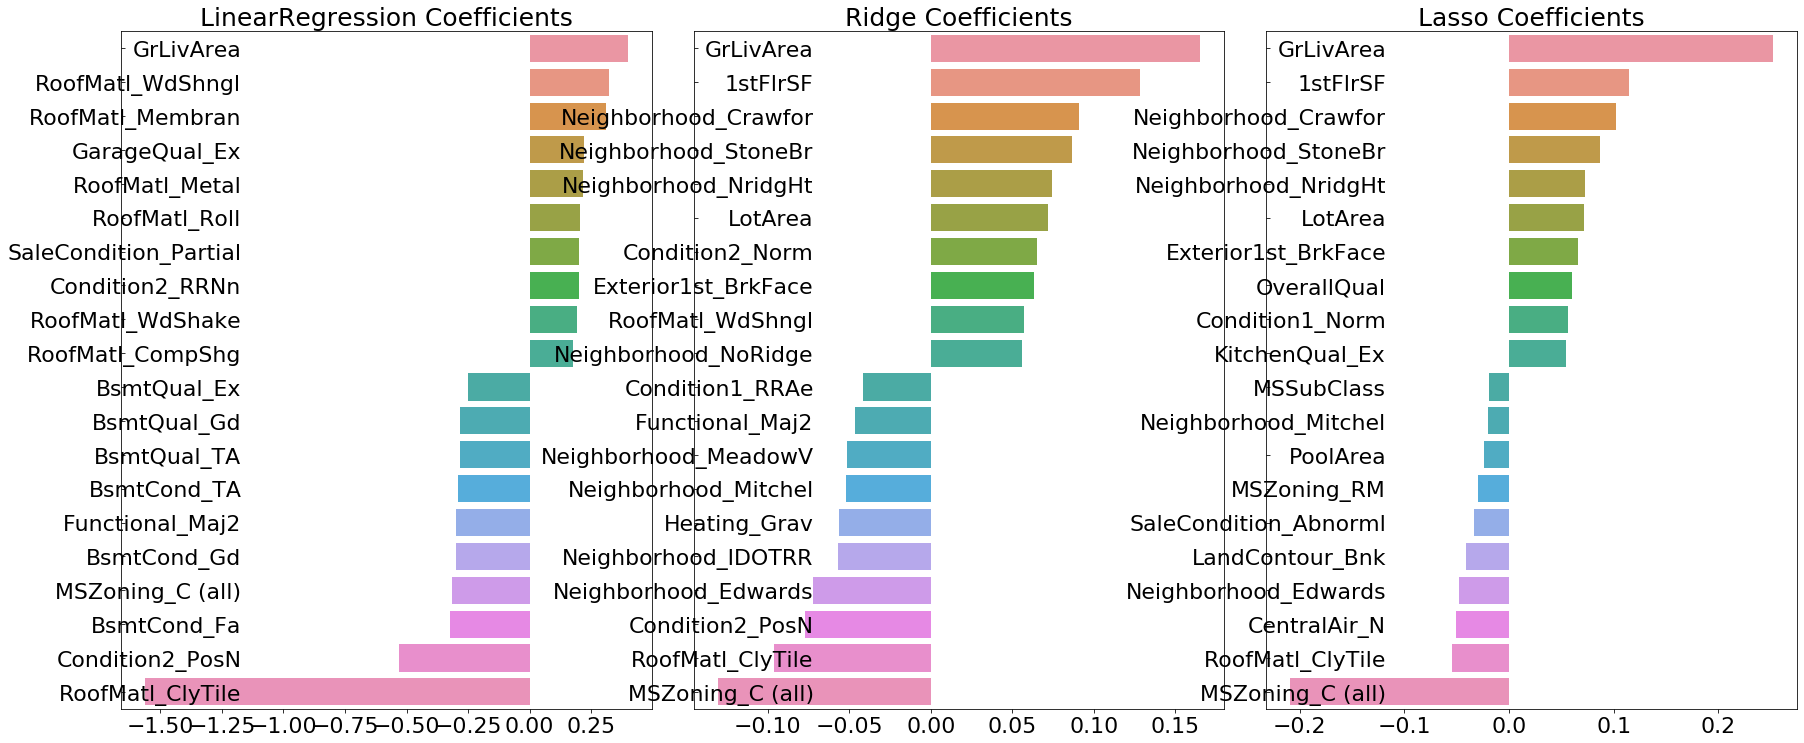

In [51]:
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

** Finally, the results meet an assumption that size of area is the most important feature on sale price

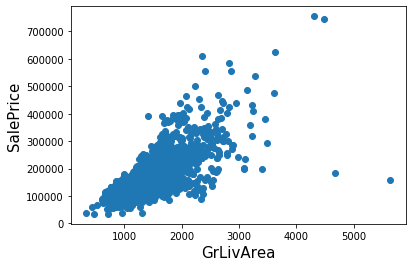

In [55]:
plt.scatter(x=house['GrLivArea'], y=house['SalePrice'])
plt.ylabel('SalePrice', fontsize=15)
plt.xlabel('GrLivArea', fontsize=15)
plt.show()

In [57]:
cond1 = house_df_ohe['GrLivArea'] > np.log1p(4000)
cond2 = house_df_ohe['SalePrice'] < np.log1p(500000)
outlier_index = house_df_ohe[cond1&cond2].index
print(outlier_index)


Int64Index([523, 1298], dtype='int64')


In [58]:
print(house_df_ohe.shape)
house_df_ohe.drop(outlier_index, axis=0, inplace=True)
print(house_df_ohe.shape)

(1460, 271)
(1458, 271)


In [59]:
y = house_df_ohe['SalePrice']
X = house_df_ohe.drop('SalePrice', axis=1, inplace=False)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=156)

In [60]:
ridge_params = {'alpha':[0.05, 0.1, 1, 5, 8, 10, 12, 15, 20]}
lasso_params = {'alpha':[0.001, 0.005, 0.008, 0.05, 0.03, 0.1, 0.5, 1, 5, 10]}

print_best_params(ridge_reg, ridge_params)
print_best_params(lasso_reg, lasso_params)

Ridge 5-FOLD-CV Best AVG RMSE: 0.1125, Best alpha: {'alpha': 8}
Lasso 5-FOLD-CV Best AVG RMSE: 0.1122, Best alpha: {'alpha': 0.001}


In [61]:
lr_reg = LinearRegression()
lr_reg.fit(X_train, y_train)

ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)

lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

models = [lr_reg, ridge_reg, lasso_reg]
get_rmses(models)

LinearRegression Log transformed RMSE: 0.129
Ridge Log transformed RMSE: 0.103
Lasso Log transformed RMSE: 0.1


[0.12864941604870517, 0.10345177546603224, 0.10024170460890021]

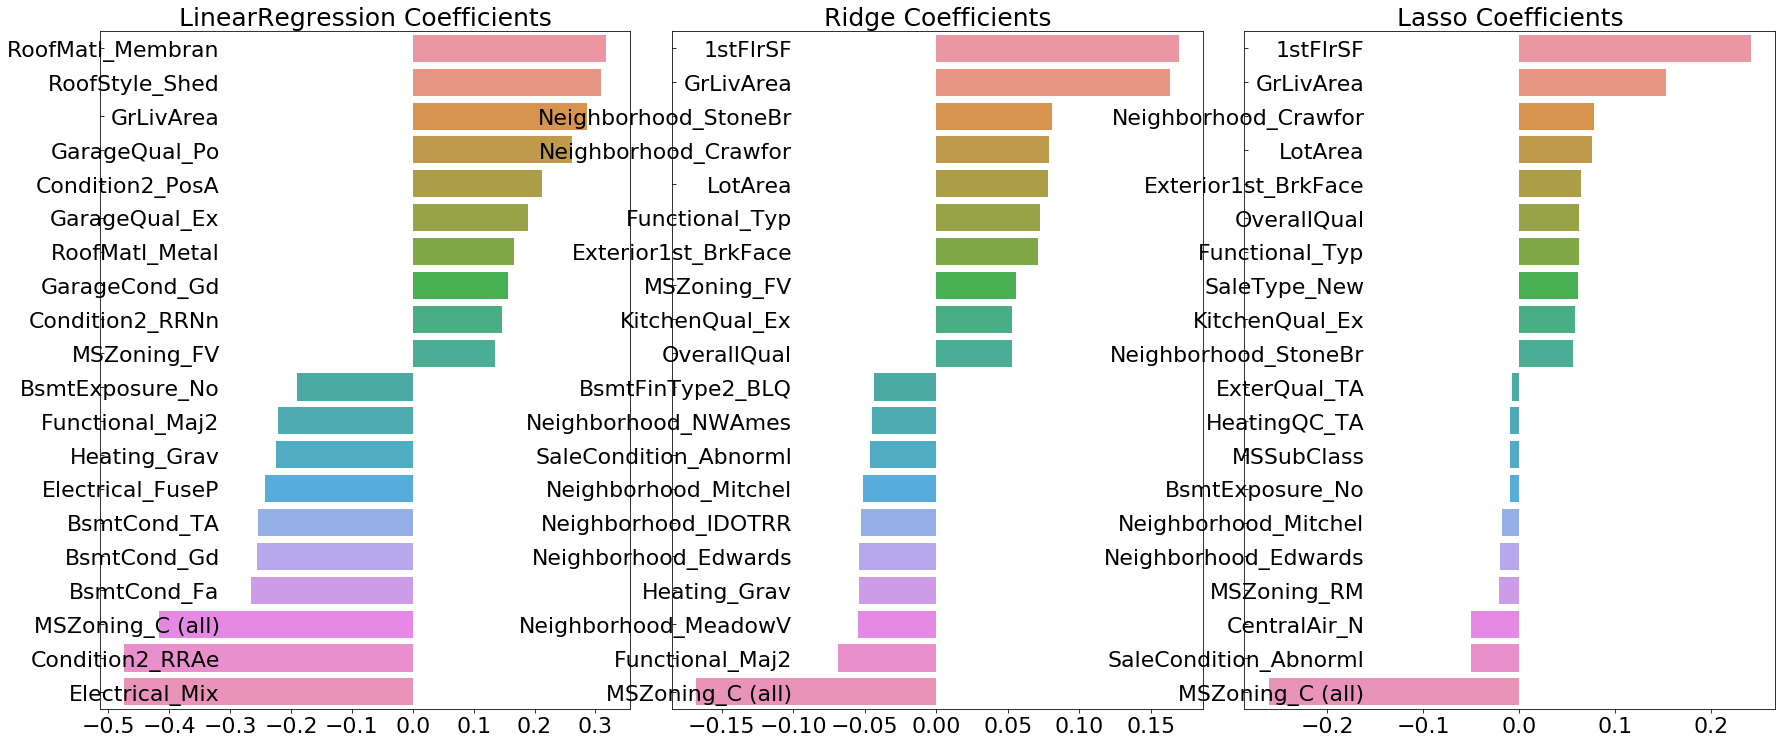

In [62]:
models = [lr_reg, ridge_reg, lasso_reg]
visualize_coefficient(models)

# Tree based regressors

In [74]:
from xgboost import XGBRegressor

xgb_params = {'n_estimators':[1000]}
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)

best_xgb = print_best_params(xgb_reg, xgb_params)

[15:38:09] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:38:16] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:38:23] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:38:31] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:38:38] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[15:38:45] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
XGBRegressor 5-FOLD-CV Best AVG RMSE: 0.1154, Best alpha: {'n_estimators': 1000}


In [75]:
from lightgbm import LGBMRegressor

lgbm_params = {'n_estimators':[1000]}
lgbm_reg = LGBMRegressor(n_estimators=1000, learning_rate=0.05, num_leaves=4, colsample_bytree=0.4, subsample=0.6, reg_lambda=10, n_jobs=-1)

best_lgbm = print_best_params(lgbm_reg, lgbm_params)

LGBMRegressor 5-FOLD-CV Best AVG RMSE: 0.1165, Best alpha: {'n_estimators': 1000}


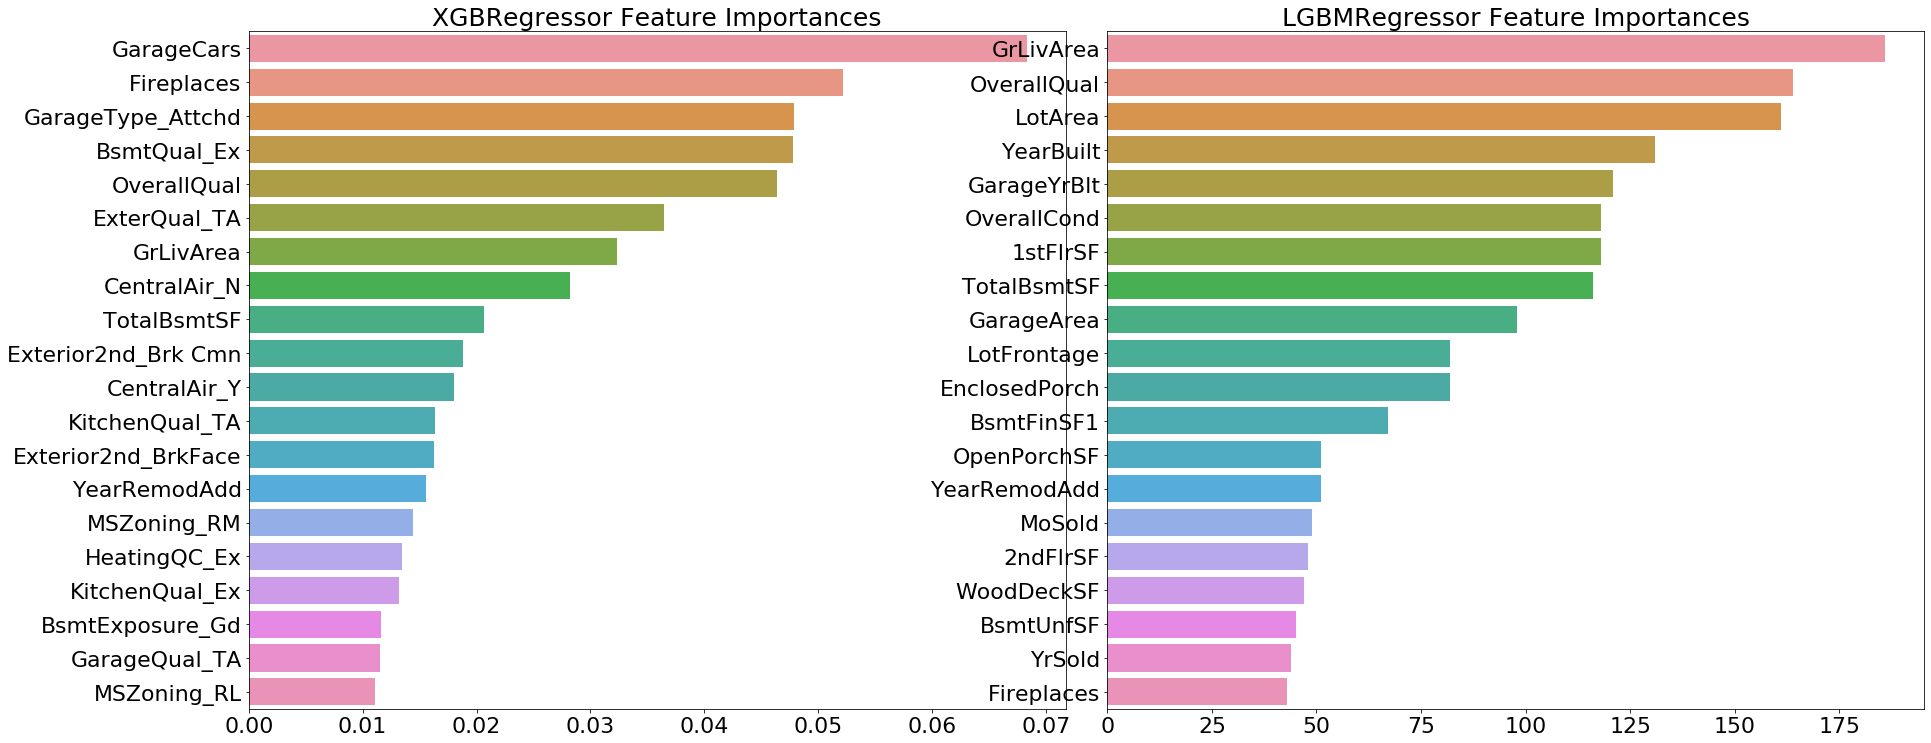

In [76]:
def get_top_features(model):
    ftr_importances_values = model.feature_importances_
    ftr_importances = pd.Series(ftr_importances_values, index=X.columns)
    ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]
    return ftr_top20

def visualize_ftr_importances(models):
    fig, axs = plt.subplots(figsize=(24,10),nrows=1, ncols=2)
    fig.tight_layout() 
    
    for i, model in enumerate(models):
        ftr_top20 = get_top_features(model)
        axs[i].set_title(model.__class__.__name__+' Feature Importances', size=25)
        # font size
        for label in (axs[i].get_xticklabels() + axs[i].get_yticklabels()):
            label.set_fontsize(22)
        sns.barplot(x=ftr_top20.values, y=ftr_top20.index , ax=axs[i])
  
models = [best_xgb, best_lgbm]
visualize_ftr_importances(models)

# Blended Prediction Results from Ridge and Lasso

In [79]:
ridge_reg = Ridge(alpha=8)
ridge_reg.fit(X_train, y_train)
lasso_reg = Lasso(alpha=0.001)
lasso_reg.fit(X_train, y_train)

ridge_pred = ridge_reg.predict(X_test)
lasso_pred = lasso_reg.predict(X_test)


pred = 0.4 * ridge_pred + 0.6 * lasso_pred

preds = {'Final Mixed prediction Results':pred, 'Ridge':ridge_pred, 'Lasso':lasso_pred}

def get_rmse_preds(preds):
    for key in preds.keys():
        pred_value = preds[key]
        mse = mean_squared_error(y_test, pred_value)
        rmse = np.sqrt(mse)
        print("{0}'s RMSE: {1}".format(key, rmse))
        
get_rmse_preds(preds)


Final Mixed prediction Results's RMSE: 0.10007930884470498
Ridge's RMSE: 0.10345177546603224
Lasso's RMSE: 0.10024170460890021


# Blended Prediction Results from XGBoost and LGBM Regressors

In [87]:
xgb_reg = XGBRegressor(n_estimators=1000, learning_rate=0.05, colsample_bytree=0.5, subsample=0.8)
lgbm_reg = LGBMRegressor(n_estimatros=1000, learning_rate=0.05, colsample_bytree=0.4, 
                         subsample=0.6, num_leaves=4, reg_lambda=10, n_jobs=-1)
xgb_reg.fit(X_train, y_train)
lgbm_reg.fit(X_train, y_train)
xgb_pred = xgb_reg.predict(X_test)
lgbm_pred = lgbm_reg.predict(X_test)

pred = 0.6 * xgb_pred + 0.4 * lgbm_pred
preds = {'Final Mixed prediction Results':pred, 'XGBM':xgb_pred, 'LGMB':lgbm_pred}

get_rmse_preds(preds)

[15:19:01] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
Final Mixed prediction Results's RMSE: 0.10275099078364168
XGBM's RMSE: 0.10330582591553708
LGMB's RMSE: 0.12220346943199471


# Stacking Ensamble Model

In [131]:
from sklearn.model_selection import KFold
from sklearn.metrics import mean_absolute_error

def get_stacking_base_datasets(model, X_train, y_train, X_test, n_folds):
    kf = KFold(n_splits=n_folds, shuffle=False, random_state=0)
    
    train_fold_pred = np.zeros((X_train.shape[0], 1))
    test_pred = np.zeros((X_test.shape[0], n_folds))
    print(model.__class__.__name__, 'model start')
    
    for folder_counter, (train_index, valid_index) in enumerate(kf.split(X_train)):
        print('\t Fold Set:', folder_counter, 'Start')
        X_tr = X_train[train_index]
        y_tr = y_train[train_index]
        X_te = X_train[valid_index]
        
        model.fit(X_tr, y_tr)
        train_fold_pred[valid_index, :] = model.predict(X_te).reshape(-1,1)
        test_pred[:, folder_counter] = model.predict(X_test)
    
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)
    
    #print(train_fold_pred, "\n")
    #print(test_pred)
    return train_fold_pred, test_pred_mean
    

In [132]:
## DataFrame to numpy array
X_train_n = X_train.values
X_test_n = X_test.values
y_train_n = y_train.values

In [133]:
ridge_train, ridge_test = get_stacking_base_datasets(ridge_reg, X_train_n, y_train_n, X_test_n, 5)
lasso_train, lasso_test = get_stacking_base_datasets(lasso_reg, X_train_n, y_train_n, X_test_n, 5)
xgb_train, xgb_test = get_stacking_base_datasets(xgb_reg, X_train_n, y_train_n, X_test_n, 5)
lgbm_train, lgbm_test = get_stacking_base_datasets(lgbm_reg, X_train_n, y_train_n, X_test_n, 5)

Ridge model start
	 Fold Set: 0 Start
	 Fold Set: 1 Start
	 Fold Set: 2 Start
	 Fold Set: 3 Start
	 Fold Set: 4 Start
[[12.7287447 ]
 [12.13354903]
 [11.46842045]
 ...
 [11.15628068]
 [12.15619687]
 [11.90427705]] 

[[11.70966834 11.6558077  11.65219938 11.6683849  11.64582046]
 [12.25236881 12.24582136 12.26638896 12.21787274 12.23961285]
 [11.94617808 11.98120308 11.99574564 11.95593844 11.95793636]
 ...
 [11.85576635 11.84791769 11.82360555 11.84744553 11.86580441]
 [11.36985705 11.31642631 11.30457399 11.33339249 11.33137656]
 [12.75247056 12.78354678 12.77496093 12.78091079 12.78384163]]
Lasso model start
	 Fold Set: 0 Start
	 Fold Set: 1 Start
	 Fold Set: 2 Start
	 Fold Set: 3 Start
	 Fold Set: 4 Start
[[12.74203176]
 [12.1238865 ]
 [11.4606494 ]
 ...
 [11.25908989]
 [12.1676623 ]
 [11.90452912]] 

[[11.67570201 11.64079319 11.63765703 11.63727445 11.63171617]
 [12.22176187 12.23354627 12.25341244 12.21119255 12.23102961]
 [11.97818999 11.99957729 12.0280473  11.99211364 11.99991

In [113]:
Stack_final_X_train = np.concatenate((ridge_train, lasso_train, xgb_train, lgbm_train), axis=1)
Stack_final_X_test = np.concatenate((ridge_test, lasso_test, xgb_test, lgbm_test), axis=1)

meta_model_lasso = Lasso(alpha=0.0005)


meta_model_lasso.fit(Stack_final_X_train, y_train)
final = meta_model_lasso.predict(Stack_final_X_test)
mse = mean_squared_error(y_test, final)
rmse = np.sqrt(mse)
rmse

0.09759517434348737